In [1]:
from model.model_initialization import * 
initialize_model(1000000, 10, 0.01, 0.02)

{'cfmm_type': '',
 'initial_values': {'token_list': ['R1', 'R2'],
  'R': [1000000, 1500000],
  'P': [2, 0.6666666666666666],
  'fee_assets': 0.01,
  'fee_HDX': 0.02},
 'agent_d': {'Trader': {'HDX': 1000000, 'R1': 1000000, 'R2': 1000000},
  'LP1': {'omniR1': 1000000},
  'LP2': {'omniR1': 1000000}},
 'action_ls': [('trade', 1000)],
 'prob_dict': {'trade': {'sell_r2_for_r1': 0, 'sell_r1_for_r2': 1}},
 'action_dict': {'sell_r2_for_r1': {'token_buy': 'R1',
   'token_sell': 'R2',
   'amount_sell': 10,
   'action_id': 'Trade',
   'agent_id': 'Trader'},
  'sell_r1_for_r2': {'token_sell': 'R1',
   'token_buy': 'R2',
   'amount_sell': 10,
   'action_id': 'Trade',
   'agent_id': 'Trader'}}}

In [2]:
import pandas as pd

from IPython.core.debugger import Pdb
ipdb = Pdb()

from model import init_utils
from model import processing
# Experiments
from model import run
from model.plot_utils import *
from model.model_initialization import * 

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

# set variables & parameters

fee_level_assets = (0.00, 0.01)
fee_level_hdx = 0.00
# uniform_data = np.random.rand(10, 12)
#trade_volume = {'10': 0.5, '20': 0.6}
#liquidity = {'1000': 0.5, '2000': 0.6}
#trade_volume = (50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000)
#liquidity = (100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000)
trade_volume = [100, 110]
liquidity = (1000000)

#create matrix for comparison
m=len(trade_volume)
n=len(fee_level_assets)
matrix = np.ndarray(shape = (m,n), dtype = int)
matrix1 = np.ndarray(shape = (m,n), dtype = int)
matrix_ror = np.ndarray(shape = (m,n), dtype = int)
matrix_ror1 = np.ndarray(shape = (m,n), dtype = int)

# index matrix
#better_index = ["X1", "X2", "Y1", "Y2", "Y3"]
#matrix.index = better_index
sim_nr = 0

for i in range(len(fee_level_assets)):
    for j in range(len(trade_volume)):
        # initialize model with starting conditions
        config_params = initialize_model(liquidity, trade_volume[j], fee_level_assets[i], fee_level_hdx)
        
        #run model
        config_dict, state = init_utils.get_configuration(config_params)

        pd.options.mode.chained_assignment = None  # default='warn'
        pd.options.display.float_format = '{:.2f}'.format
        
        run.config(config_dict, state)
        events = run.run()
        
        rdf, agent_df = processing.postprocessing(events)
        
        # calculate profitability metrics; change in pool values
         
        print(sim_nr)
        total_timesteps = 1000
        first_timestep = 1
        
        ## merge agent and pool dataframes
        profit_results = pd.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])
        
        ## assign additional columns
        profit_results['val_pool'] = profit_results.apply(lambda x: processing.val_pool(x), axis=1)
        initial_values = config_params['initial_values']
        agent_d = config_params['agent_d']
        withdraw_agent_d = processing.get_withdraw_agent_d(initial_values, agent_d)
        print(withdraw_agent_d)
        profit_results['val_hold'] = profit_results.apply(lambda x: processing.val_hold(x, withdraw_agent_d), axis=1)
        profit_results['IL'] = profit_results.apply(lambda x: x['val_pool']/x['val_hold'] - 1, axis=1)
        profit_results['pool_val'] = profit_results.apply(lambda x: processing.pool_val(x), axis=1)
        
        ## calculate profits from 'val_pool' and 'pool_val'        
        profit_results1 = profit_results[profit_results['simulation'] == sim_nr]
        profit_results2 = profit_results1[profit_results1['timestep'] == total_timesteps]
        profit_results3 = profit_results1[profit_results1['timestep'] == first_timestep]
        profit_results4 = profit_results2[profit_results2['agent_label'] == 'LP2'] #define selection for final timestep for desired agent (LP1 / LP2 / ??)
        profit_results5 = profit_results3[profit_results3['agent_label'] == 'LP2'] #define selection for first timestep for desired agent (LP1 / LP2 / ??)
        profit_sim0 = profit_results4['val_pool'].iloc[0] - profit_results5['val_pool'].iloc[0] # changed to 4 - 5 inst. of 2 - 3
        profit_sim1 = profit_results4['pool_val'].iloc[0] - profit_results5['pool_val'].iloc[0] # changed to 4 - 5 inst. of 2 - 3
        
        #backup
        #profit_sim0 = profit_results2['val_pool'].iloc[0] - profit_results3['val_pool'].iloc[0] # changed to 4 - 5 inst. of 2 - 3
        #profit_sim1 = profit_results2['pool_val'].iloc[0] - profit_results3['pool_val'].iloc[0] # changed to 4 - 5 inst. of 2 - 3
        
        ## calculate 'rate of return'
        ror0 = (profit_sim0 / agent_d['LP1']['omniR1']) * 10000
        ror1 = (profit_sim1 / agent_d['LP1']['omniR1']) * 10000
                    
        # assign metrics to matrix
        #matrix[j][i] = np.random.randint(1, 100 + 1)
        #matrix[j][i] = trade_volume[i]*liquidity[j]
        matrix[j][i] = profit_sim0
        matrix1[j][i] = profit_sim1
        matrix_ror[j][i] = ror0
        matrix_ror1[j][i] = ror1
        ## increase simulation count
        sim_nr += 1




                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1000, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.91s
0
{'Trader': {'q': 1000000, 's': [0, 0], 'r': [1000000, 1000000], 'p': [0, 0]}, 'LP1': {'q': 0.0, 's': [0, 0], 'r': [1000000.0, 0], 'p': [2.0, 0]}, 'LP2': {'q': 0.0, 's': [0, 0], 'r': [1000000.0, 0], 'p': [2.0, 0]}}

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 2
Dimensions of the first simulation: 

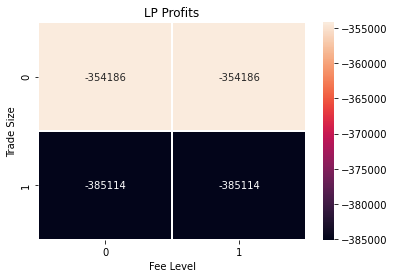

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

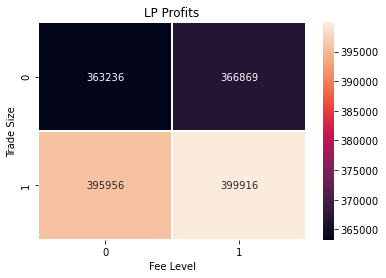

In [4]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix1, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

In [5]:
matrix_ror

array([[-3541, -3541],
       [-3851, -3851]])

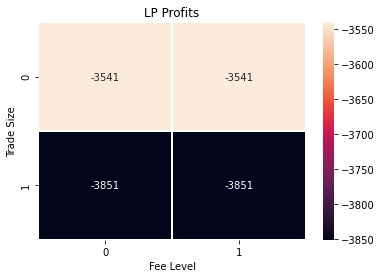

In [6]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

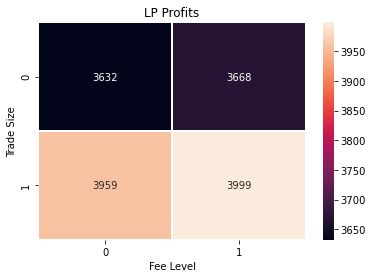

In [7]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror1, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

In [8]:
profit_results2['val_pool'].iloc[0]

3636569.939536444

In [9]:
profit_results3['val_pool'].iloc[0]

3666517.9449279155

In [10]:
profit_results2['pool_val'].iloc[0]

2400361.0814564996

In [11]:
profit_results3['pool_val'].iloc[0]

2000444.3520891634

In [12]:
agent_d['LP1']['omniR1']

1000000

[0]


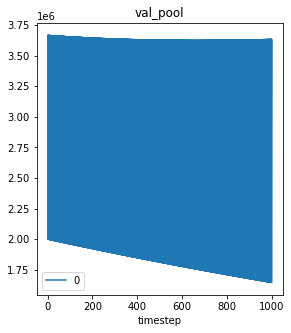

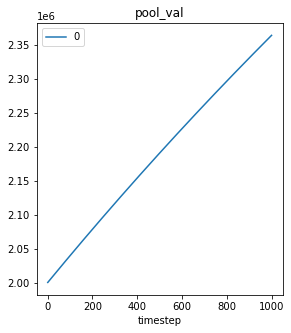

In [13]:
from model import plot_utils as pu
varlist = ['val_pool', 'pool_val']
dataframe = profit_results[profit_results['simulation'] == 0]
pu.plot_vars(dataframe, varlist)

## Merge Results

In [14]:
        profit_results = pd.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])
        profit_results['val_pool'] = profit_results.apply(lambda x: processing.val_pool(x), axis=1)
        profit_sim0 = profit_results.apply(lambda x: processing.val_pool(x), axis=1)

In [15]:
profit_results

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,...,B-1,D,T,H,token_list-0,token_list-1,fee_assets,fee_HDX,n,val_pool
0,0,0,1,3,1,Trader,1000000.00,0,0,999900,...,1500000,0.00,None,None,R1,R2,0.00,0.00,2,3666533.45
1,0,0,1,3,1,LP1,0.00,1000000,0,0,...,1500000,0.00,None,None,R1,R2,0.00,0.00,2,1999600.05
2,0,0,1,3,1,LP2,0.00,1000000,0,0,...,1500000,0.00,None,None,R1,R2,0.00,0.00,2,1999600.05
3,0,0,1,3,2,Trader,1000000.00,0,0,999800,...,1500000,0.00,None,None,R1,R2,0.00,0.00,2,3666400.48
4,0,0,1,3,2,LP1,0.00,1000000,0,0,...,1500000,0.00,None,None,R1,R2,0.00,0.00,2,1999200.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,3,0,1,3,999,LP1,0.00,1000000,0,0,...,1500000,0.00,None,None,R1,R2,0.01,0.00,2,1614782.07
11996,3,0,1,3,999,LP2,0.00,1000000,0,0,...,1500000,0.00,None,None,R1,R2,0.01,0.00,2,1614782.07
11997,3,0,1,3,1000,Trader,1000000.00,0,0,890000,...,1500000,0.00,None,None,R1,R2,0.01,0.00,2,3636569.94
11998,3,0,1,3,1000,LP1,0.00,1000000,0,0,...,1500000,0.00,None,None,R1,R2,0.01,0.00,2,1614445.41


In [16]:
#profit_results1 = profit_results[profit_results['simulation'] == sim_nr]
#profit_results2 = profit_results1[profit_results1['timestep'] == total_timesteps]
#profit_results2['val_pool'].iloc[0]

In [17]:
#print(profit_results.columns)

In [18]:
#profit_sim0

In [19]:
profit_results1

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,...,H,token_list-0,token_list-1,fee_assets,fee_HDX,n,val_pool,val_hold,IL,pool_val
9000,3,0,1,3,1,Trader,1000000.00,0,0,999890,...,None,R1,R2,0.01,0.00,2,3666517.94,3666520.07,-0.00,2000444.35
9001,3,0,1,3,1,LP1,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1999560.06,1999560.07,-0.00,2000444.35
9002,3,0,1,3,1,LP2,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1999560.06,1999560.07,-0.00,2000444.35
9003,3,0,1,3,2,Trader,1000000.00,0,0,999780,...,None,R1,R2,0.01,0.00,2,3666369.51,3666373.62,-0.00,2000888.61
9004,3,0,1,3,2,LP1,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1999120.24,1999120.29,-0.00,2000888.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,3,0,1,3,999,LP1,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1614782.07,1623566.64,-0.01,2400000.36
11996,3,0,1,3,999,LP2,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1614782.07,1623566.64,-0.01,2400000.36
11997,3,0,1,3,1000,Trader,1000000.00,0,0,890000,...,None,R1,R2,0.01,0.00,2,3636569.94,3580069.89,0.02,2400361.08
11998,3,0,1,3,1000,LP1,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1614445.41,1623244.87,-0.01,2400361.08


In [20]:
profit_results2

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,...,H,token_list-0,token_list-1,fee_assets,fee_HDX,n,val_pool,val_hold,IL,pool_val
11997,3,0,1,3,1000,Trader,1000000.00,0,0,890000,...,None,R1,R2,0.01,0.00,2,3636569.94,3580069.89,0.02,2400361.08
11998,3,0,1,3,1000,LP1,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1614445.41,1623244.87,-0.01,2400361.08
11999,3,0,1,3,1000,LP2,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1614445.41,1623244.87,-0.01,2400361.08


In [21]:
profit_results3

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,...,H,token_list-0,token_list-1,fee_assets,fee_HDX,n,val_pool,val_hold,IL,pool_val
9000,3,0,1,3,1,Trader,1000000.00,0,0,999890,...,None,R1,R2,0.01,0.00,2,3666517.94,3666520.07,-0.00,2000444.35
9001,3,0,1,3,1,LP1,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1999560.06,1999560.07,-0.00,2000444.35
9002,3,0,1,3,1,LP2,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1999560.06,1999560.07,-0.00,2000444.35


In [22]:
profit_results3['val_pool'].iloc[0]

3666517.9449279155

In [23]:
profit_results4 = profit_results3[profit_results3['agent_label'] == 'LP1']
profit_results4

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,...,H,token_list-0,token_list-1,fee_assets,fee_HDX,n,val_pool,val_hold,IL,pool_val
9001,3,0,1,3,1,LP1,0.00,1000000,0,0,...,None,R1,R2,0.01,0.00,2,1999560.06,1999560.07,-0.00,2000444.35


In [24]:
profit_results4['val_pool'].iloc[0]

1999560.0604933458

In [25]:
profit_results5['val_pool'].iloc[0]

1999560.0604933458


var_list = ['R', 'Q', 'A', 'D']
plot_vars(rdf, var_list)

## Fee Analysis

In [26]:
rdf

,R-0,R-1,Q-0,Q-1,S-0,S-1,A-0,A-1,B-0,B-1,...,token_list-0,token_list-1,fee_assets,fee_HDX,n,simulation,subset,run,substep,timestep
3,1000100,1499700.09,1999800.02,1000199.98,1000000,1500000,0,0,-1000000,1500000,...,R1,R2,0.00,0.00,2,0,0,1,3,1
6,1000200,1499400.36,1999600.08,1000399.92,1000000,1500000,0,0,-1000000,1500000,...,R1,R2,0.00,0.00,2,0,0,1,3,2
9,1000300,1499100.81,1999400.18,1000599.82,1000000,1500000,0,0,-1000000,1500000,...,R1,R2,0.00,0.00,2,0,0,1,3,3
12,1000400,1498801.44,1999200.32,1000799.68,1000000,1500000,0,0,-1000000,1500000,...,R1,R2,0.00,0.00,2,0,0,1,3,4
15,1000500,1498502.25,1999000.50,1000999.50,1000000,1500000,0,0,-1000000,1500000,...,R1,R2,0.00,0.00,2,0,0,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11991,1109560,1255076.22,1802516.31,1199458.88,1000000,1500000,0,0,-1000000,1500000,...,R1,R2,0.01,0.00,2,3,0,1,3,996
11994,1109670,1254891.15,1802337.63,1199639.35,1000000,1500000,0,0,-1000000,1500000,...,R1,R2,0.01,0.00,2,3,0,1,3,997
11997,1109780,1254706.17,1802158.99,1199819.78,1000000,1500000,0,0,-1000000,1500000,...,R1,R2,0.01,0.00,2,3,0,1,3,998
12000,1109890,1254521.29,1801980.38,1200000.18,1000000,1500000,0,0,-1000000,1500000,...,R1,R2,0.01,0.00,2,3,0,1,3,999


In [27]:
print(rdf.columns)

Index(['R-0', 'R-1', 'Q-0', 'Q-1', 'S-0', 'S-1', 'A-0', 'A-1', 'B-0', 'B-1',
       'D', 'T', 'H', 'token_list-0', 'token_list-1', 'fee_assets', 'fee_HDX',
       'n', 'simulation', 'subset', 'run', 'substep', 'timestep'],
      dtype='object')


In [28]:
print(rdf.keys)

<bound method NDFrame.keys of            R-0        R-1        Q-0        Q-1      S-0      S-1  A-0  A-1  \
3      1000100 1499700.09 1999800.02 1000199.98  1000000  1500000    0    0   
6      1000200 1499400.36 1999600.08 1000399.92  1000000  1500000    0    0   
9      1000300 1499100.81 1999400.18 1000599.82  1000000  1500000    0    0   
12     1000400 1498801.44 1999200.32 1000799.68  1000000  1500000    0    0   
15     1000500 1498502.25 1999000.50 1000999.50  1000000  1500000    0    0   
...        ...        ...        ...        ...      ...      ...  ...  ...   
11991  1109560 1255076.22 1802516.31 1199458.88  1000000  1500000    0    0   
11994  1109670 1254891.15 1802337.63 1199639.35  1000000  1500000    0    0   
11997  1109780 1254706.17 1802158.99 1199819.78  1000000  1500000    0    0   
12000  1109890 1254521.29 1801980.38 1200000.18  1000000  1500000    0    0   
12003  1110000 1254336.49 1801801.80 1200180.54  1000000  1500000    0    0   

           B-0      B

In [29]:
agent_df

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,r-1,p-0,p-1
9,0,0,1,3,1,Trader,1000000.00,0,0,999900,1000299.91,0.00,0
10,0,0,1,3,1,LP1,0.00,1000000,0,0,0.00,2.00,0
11,0,0,1,3,1,LP2,0.00,1000000,0,0,0.00,2.00,0
18,0,0,1,3,2,Trader,1000000.00,0,0,999800,1000599.64,0.00,0
19,0,0,1,3,2,LP1,0.00,1000000,0,0,0.00,2.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36001,3,0,1,3,999,LP1,0.00,1000000,0,0,0.00,2.00,0
36002,3,0,1,3,999,LP2,0.00,1000000,0,0,0.00,2.00,0
36009,3,0,1,3,1000,Trader,1000000.00,0,0,890000,1245663.51,0.00,0
36010,3,0,1,3,1000,LP1,0.00,1000000,0,0,0.00,2.00,0


In [30]:
agent_df.query('agent_label=="LP1"')

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,r-1,p-0,p-1
10,0,0,1,3,1,LP1,0.00,1000000,0,0,0.00,2.00,0
19,0,0,1,3,2,LP1,0.00,1000000,0,0,0.00,2.00,0
28,0,0,1,3,3,LP1,0.00,1000000,0,0,0.00,2.00,0
37,0,0,1,3,4,LP1,0.00,1000000,0,0,0.00,2.00,0
46,0,0,1,3,5,LP1,0.00,1000000,0,0,0.00,2.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35974,3,0,1,3,996,LP1,0.00,1000000,0,0,0.00,2.00,0
35983,3,0,1,3,997,LP1,0.00,1000000,0,0,0.00,2.00,0
35992,3,0,1,3,998,LP1,0.00,1000000,0,0,0.00,2.00,0
36001,3,0,1,3,999,LP1,0.00,1000000,0,0,0.00,2.00,0


## How to metric

In [31]:
rdf.loc[(rdf['simulation'] == 0) & (rdf['timestep'] == 1000)]['R-1']

3000   1269230.77
Name: R-1, dtype: float64

In [32]:
#import pandas as pd
#rdf.get_value('simulation' == 0 )]
rdf1 = rdf[rdf["simulation"] == 0]
rdf2 = rdf1[rdf1["timestep"] == 1000]
x_0 = rdf2['R-0'].iloc[0]
x_0


1100000

In [33]:
rdf.loc[(rdf['simulation'] == 1) & (rdf['timestep'] == 1000)]['R-1']

6001   1251879.70
Name: R-1, dtype: float64

In [34]:
rdf.loc[(rdf['simulation'] == 2) & (rdf['timestep'] == 1000)]['R-1']

9002   1271518.95
Name: R-1, dtype: float64

In [35]:
rdf.loc[(rdf['simulation'] == 3) & (rdf['timestep'] == 1000)]['R-1']

12003   1254336.49
Name: R-1, dtype: float64

In [36]:
rdf.loc[(rdf['simulation'] == 0) & (rdf['timestep'] == 1)]['R-1']

3   1499700.09
Name: R-1, dtype: float64

In [37]:
rdf.loc[(rdf['simulation'] == 1) & (rdf['timestep'] == 1)]['R-1']

3004   1499670.11
Name: R-1, dtype: float64

In [38]:
rdf.loc[(rdf['simulation'] == 2) & (rdf['timestep'] == 1)]['R-1']

6005   1499703.09
Name: R-1, dtype: float64

In [39]:
rdf.loc[(rdf['simulation'] == 3) & (rdf['timestep'] == 1)]['R-1']

9006   1499673.41
Name: R-1, dtype: float64

### Calculate change in pool value

#### R-0

In [40]:
rdf1 = rdf[rdf["simulation"] == 0]
rdf2 = rdf1[rdf1["timestep"] == 1000]
r0_1 = rdf2['R-0'].iloc[0]
r0_1

1100000

In [41]:
rdf1 = rdf[rdf["simulation"] == 0]
rdf2 = rdf1[rdf1["timestep"] == 1]
r0_0 = rdf2['R-0'].iloc[0]
r0_0

1000100

In [42]:
profit_sim0_r0 = r0_1 - r0_0
profit_sim0_r0

99900

#### R-1

In [43]:
rdf1 = rdf[rdf["simulation"] == 0]
rdf2 = rdf1[rdf1["timestep"] == 1000]
r1_1 = rdf2['R-1'].iloc[0]
r1_1

1269230.7692307646

In [44]:
rdf1 = rdf[rdf["simulation"] == 0]
rdf2 = rdf1[rdf1["timestep"] == 1]
r1_0 = rdf2['R-1'].iloc[0]
r1_0

1499700.0899730083

In [45]:
profit_sim0_r1 = r1_1 - r1_0
profit_sim0_r1

-230469.32074224367

#### Total pool value

In [46]:
profit_sim0_r1 + profit_sim0_r0

-130569.32074224367

## How to heatmap

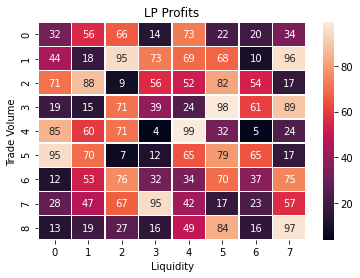

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

# set variables & parameters

fee_level = 0.03
# uniform_data = np.random.rand(10, 12)
#trade_volume = {'10': 0.5, '20': 0.6}
#liquidity = {'1000': 0.5, '2000': 0.6}
trade_volume = (50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000)
liquidity = (100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000)

#create matrix for comparison
m=len(trade_volume)
n=len(liquidity)
matrix = np.ndarray(shape = (m,n), dtype = int)

# index matrix
#better_index = ["X1", "X2", "Y1", "Y2", "Y3"]
#matrix.index = better_index

# fill in matrix with calculation results
for i in range(len(liquidity)):
    for j in range(len(trade_volume)):
        matrix[j][i] = np.random.randint(1, 100 + 1)




#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Liquidity')
ax.set_ylabel('Trade Volume')
plt.show()

In [48]:
matrix

array([[32, 56, 66, 14, 73, 22, 20, 34],
       [44, 18, 95, 73, 69, 68, 10, 96],
       [71, 88,  9, 56, 52, 82, 54, 17],
       [19, 15, 71, 39, 24, 98, 61, 89],
       [85, 60, 71,  4, 99, 32,  5, 24],
       [95, 70,  7, 12, 65, 79, 65, 17],
       [12, 53, 76, 32, 34, 70, 37, 75],
       [28, 47, 67, 95, 42, 17, 23, 57],
       [13, 19, 27, 16, 49, 84, 16, 97]])

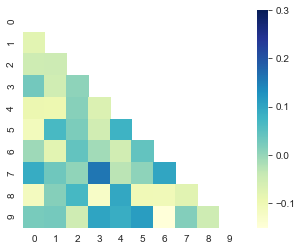

In [49]:
corr = np.corrcoef(np.random.randn(10, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()

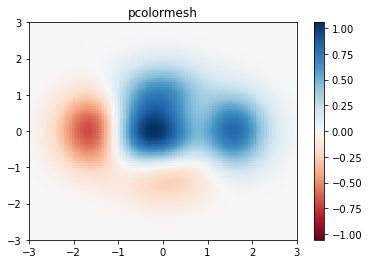

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

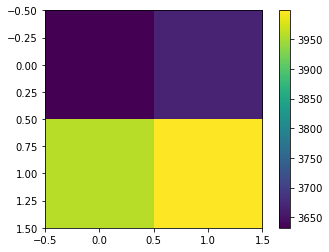

In [51]:
import matplotlib.pyplot as plt
import numpy as np


def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()


test_array = np.arange(100 * 100).reshape(100, 100)
heatmap2d(matrix_ror1)

In [52]:
trade_volume

(50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000)